In [1]:
# Import dependencies.
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [2]:
engine = create_engine("sqlite:///open_university.sqlite", echo=False)

## Load the data

The plan is to just look at the interaction with the course material to see if the student will be able to predict if the student will pass or fail.

Not including information about the background of the student (demographics) or the scores of the student assessments but include if they submit the assessments or not.

We are going to filter out students that withdraw from the course before the start of the course.

In [38]:
student_ds = engine.execute(text("""
SELECT sI.code_module, sI.code_presentation, sI.id_student, sI.final_result, sR.date_registration, sR.date_unregistration
FROM studentInfo as sI
LEFT JOIN studentRegistration as sR ON sI.id_student = sR.id_student
WHERE NOT (sR.date_unregistration <= -11 AND sI.final_result = 'Withdrawn')
""")).fetchall()

student_df = pd.DataFrame(student_ds, columns=['code_module', 'code_presentation', 'id_student', 'final_result', 'date_registration', 'date_unregistration'])

student_df = student_df.astype({'code_module':'string', 'code_presentation':'string', 'id_student':'string', 'final_result':'string'})

display(student_df)
display(student_df.info())


,code_module,code_presentation,id_student,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,Pass,-159.0,NaN
1,AAA,2013J,28400,Pass,-53.0,NaN
2,AAA,2013J,30268,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,Pass,-52.0,NaN
4,AAA,2013J,32885,Pass,-176.0,NaN
...,...,...,...,...,...,...
36683,GGG,2014J,2640965,Fail,-4.0,NaN
36684,GGG,2014J,2645731,Distinction,-23.0,NaN
36685,GGG,2014J,2648187,Pass,-129.0,NaN
36686,GGG,2014J,2679821,Withdrawn,-49.0,101.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36688 entries, 0 to 36687
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          36688 non-null  string 
 1   code_presentation    36688 non-null  string 
 2   id_student           36688 non-null  string 
 3   final_result         36688 non-null  string 
 4   date_registration    36666 non-null  float64
 5   date_unregistration  11592 non-null  float64
dtypes: float64(2), string(4)
memory usage: 1.7 MB


None

In [44]:
## need to add the Vle connected to Student Vle
vle_ds = engine.execute(text("""
SELECT vle.id_site, vle.code_module, vle.code_presentation, vle.activity_type, vle.week_from, vle.week_to, sVle.id_student, sVle.date, SUM(sVLe.sum_click) as sum_click
FROM vle
LEFT JOIN studentVle AS sVle ON vle.id_site = sVle.id_site AND vle.code_presentation = sVle.code_presentation AND vle.code_module = sVle.code_module
GROUP BY vle.code_module, vle.code_presentation, sVle.id_student
""")).fetchall()

vle_df = pd.DataFrame(vle_ds, columns=['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to', 'id_student', 'date', 'sum_click'])

display(vle_df)
display(vle_df.info())


,id_site,code_module,code_presentation,activity_type,week_from,week_to,id_student,date,sum_click
0,546897,AAA,2013J,url,NaN,NaN,NaN,NaN,NaN
1,546614,AAA,2013J,homepage,NaN,NaN,11391.0,-5.0,934.0
2,546614,AAA,2013J,homepage,NaN,NaN,28400.0,-10.0,1435.0
3,546614,AAA,2013J,homepage,NaN,NaN,30268.0,-10.0,281.0
4,546614,AAA,2013J,homepage,NaN,NaN,31604.0,-10.0,2158.0
...,...,...,...,...,...,...,...,...,...
29240,897051,GGG,2014J,resource,2.0,2.0,2640965.0,17.0,41.0
29241,896962,GGG,2014J,oucontent,NaN,NaN,2645731.0,110.0,893.0
29242,896956,GGG,2014J,quiz,NaN,NaN,2648187.0,149.0,312.0
29243,897051,GGG,2014J,resource,2.0,2.0,2679821.0,-6.0,275.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29245 entries, 0 to 29244
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            29245 non-null  int64  
 1   code_module        29245 non-null  object 
 2   code_presentation  29245 non-null  object 
 3   activity_type      29245 non-null  object 
 4   week_from          4705 non-null   float64
 5   week_to            4705 non-null   float64
 6   id_student         29228 non-null  float64
 7   date               29228 non-null  float64
 8   sum_click          29228 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 2.0+ MB


None

In [107]:
dataset1 = engine.execute(text("""
SELECT id_student, date
FROM studentVle as sVle
--LIMIT 100000
""")).fetchall()

df_interaction_date = pd.DataFrame(dataset1, columns=['id_student', 'day'])
df_interaction_date[["day"]].describe()

OperationalError: (sqlite3.OperationalError) no such column: sR.date_unregistration
[SQL: 
SELECT id_student, date
FROM studentVle as sVle
WHERE sR.date_unregistration <= -11 AND sI.final_result <> 'Withdrawn'
--LIMIT 100000
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [15]:
dataset2 = engine.execute(text("""
SELECT sAss.id_assessment, sAss.date_submitted, ass.date
FROM studentAssessment as sAss
OUTER LEFT JOIN assessments as ass ON sAss.id_assessment = ass.id_assessment
OUTER LEFT JOIN studentRegistration as sR ON sAss.id_student = sR.id_student
OUTER RIGHT JOIN studentInfo as sI ON sAss.id_student = sR.id_student
--WHERE NOT (sR.date_unregistration <= -11 AND sI.final_result = 'Withdrawn')
--LIMIT 100000
""")).fetchall()

df_interaction_assessment_date = pd.DataFrame(dataset2, columns=['id_assessent', 'date_submitted', 'date'])
df_interaction_assessment_date[["date_submitted", "date"]].describe()

In [5]:
display(df[["date_registration", "date_unregistration"]].describe())
display(df.count())
display(df)

,day,clicks,date_registration,date_unregistration
count,1.809549e+07,1.809549e+07,1.808883e+07,3.367247e+06
mean,9.338963e+01,3.691653e+00,-7.270610e+01,8.470535e+01
std,7.597023e+01,9.087302e+00,5.086778e+01,8.739664e+01
min,-2.500000e+01,1.000000e+00,-3.200000e+02,-3.650000e+02
25%,2.400000e+01,1.000000e+00,-1.060000e+02,2.000000e+01
50%,8.200000e+01,2.000000e+00,-6.000000e+01,9.000000e+01
75%,1.530000e+02,3.000000e+00,-3.000000e+01,1.560000e+02
max,2.690000e+02,6.977000e+03,1.670000e+02,4.440000e+02


id_student              18095487
code_module             18095487
code_presentation       18095487
day                     18095487
clicks                  18095487
num_of_prev_attempts    18095487
date_registration       18088833
date_unregistration      3367247
final_result            18095487
dtype: int64

,id_student,code_module,code_presentation,day,clicks,num_of_prev_attempts,date_registration,date_unregistration,final_result
0,28400,AAA,2013J,-10,4,0,-53.0,NaN,Pass
1,28400,AAA,2013J,-10,1,0,-53.0,NaN,Pass
2,28400,AAA,2013J,-10,1,0,-53.0,NaN,Pass
3,28400,AAA,2013J,-10,11,0,-53.0,NaN,Pass
4,28400,AAA,2013J,-10,1,0,-53.0,NaN,Pass
...,...,...,...,...,...,...,...,...,...
18095482,675811,GGG,2014J,269,3,0,-63.0,NaN,Distinction
18095483,675578,GGG,2014J,269,1,0,-32.0,NaN,Pass
18095484,654064,GGG,2014J,269,3,0,-16.0,NaN,Pass
18095485,654064,GGG,2014J,269,1,0,-16.0,NaN,Pass


In [85]:
#df = df.astype({'gender':'string', 'imd_band':'string', 'highest_education':'string', 'age_band':'string', 'region':'string', 'final_result':'string'})
#df.dtypes


In [8]:
display(df.nunique())
#display(df.value_counts("gender"))
#display(df.value_counts("imd_band"))
#display(df.value_counts("highest_education"))
#print(f"A-Level is equivilent to high school cert, HE Qualification is level 1 ro 2 of University, ")
#display(df.value_counts("age_band"))
#display(df.value_counts("num_of_prev_attempts"))
#display(df.value_counts("region"))
display(df.value_counts("final_result"))

id_student              2189
code_module                5
code_presentation          4
day                      294
clicks                   149
num_of_prev_attempts       6
date_registration        201
date_unregistration      180
final_result               4
dtype: int64

final_result
Pass           327403
Withdrawn       64911
Distinction     61931
Fail            45755
Name: count, dtype: int64

In [24]:
# distinction is a higher form of pass
# withdrawn would be a fail if the student would not complete the course both fail and withdrawn is a form of failure.
# Possible to remove withdrawn
df_edited = df.copy()
df_edited["final_result"] = df_edited["final_result"].replace({'Distinction': 'Pass', 'Withdrawn': 'Fail'})
df_edited["final_result"] = df_edited["final_result"].replace({'Pass': '1', 'Fail': '0'})
df_edited = df_edited.astype({'day': 'float32', 'clicks': 'float32', 'num_of_prev_attempts': 'float32', 'final_result': 'float32'})
display(df_edited["final_result"].unique())
display(df_edited.dtypes)

array([1., 0.], dtype=float32)

id_student               object
code_module              object
code_presentation        object
day                     float32
clicks                  float32
num_of_prev_attempts    float32
date_registration       float64
date_unregistration     float64
final_result            float32
dtype: object

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [14]:
df_edited = pd.get_dummies(df_edited)
df_edited.head()

,id_student,day,clicks,num_of_prev_attempts,date_registration,date_unregistration,final_result,code_module_AAA,code_module_BBB,code_module_DDD,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J
0,28400.0,-10.0,4.0,0.0,-53.0,NaN,1.0,True,False,False,False,False,False,True,False,False
1,28400.0,-10.0,1.0,0.0,-53.0,NaN,1.0,True,False,False,False,False,False,True,False,False
2,28400.0,-10.0,1.0,0.0,-53.0,NaN,1.0,True,False,False,False,False,False,True,False,False
3,28400.0,-10.0,11.0,0.0,-53.0,NaN,1.0,True,False,False,False,False,False,True,False,False
4,28400.0,-10.0,1.0,0.0,-53.0,NaN,1.0,True,False,False,False,False,False,True,False,False


In [15]:
# combine pass and distinction
# combine widthdrawn and fail
X = df_edited.drop('final_result', axis=1).values
y = df_edited['final_result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [16]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled.shape

(375000, 15)

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])

# X shape / input feature / columns rule of thumbs is normally 2-3 times the ammount so 43 * 2 or 3 is 86-129 so i will try choosing 90 for the first hidden node
hidden_nodes1 = 90
hidden_nodes2 = 60
hidden_nodes3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes1, input_shape=(number_input_features,), activation='relu'))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes2, activation='relu'))
# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes3, activation='relu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# Check the structure of the model
nn.summary()

/Users/horsewell/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 90)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         5,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,761 (34.22 KB)

 Trainable params: 8,761 (34.22 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train, epochs=20)

Epoch 1/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 6s 462us/step - accuracy: 0.2189 - loss: nan
Epoch 2/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 444us/step - accuracy: 0.2216 - loss: nan
Epoch 3/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 455us/step - accuracy: 0.2204 - loss: nan
Epoch 4/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 461us/step - accuracy: 0.2207 - loss: nan
Epoch 5/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 441us/step - accuracy: 0.2210 - loss: nan
Epoch 6/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 452us/step - accuracy: 0.2207 - loss: nan
Epoch 7/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 6s 471us/step - accuracy: 0.2201 - loss: nan
Epoch 8/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 449us/step - accuracy: 0.2205 - loss: nan
Epoch 9/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 458us/step - accuracy: 0.2214 - loss: nan
Epoch 10/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 6s 473us/step - accuracy: 0.2211 - loss: nan
Epoch 11/20
11719/11719 ━━━━━━━━━━━━━━━━━━━━ 5s 446us/step - accuracy: 0.2213 - loss: nan
Epoch 12/20
11719/1

In [94]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3045/3045 - 1s - 304us/step - accuracy: 0.6720 - loss: nan
Loss: nan, Accuracy: 0.6720041036605835


In [95]:
# Export our model to HDF5 file
nn.save("models/Student_Pass1Fail_relu90+relu60+relu30+sigmoid.h5")

<Axes: >

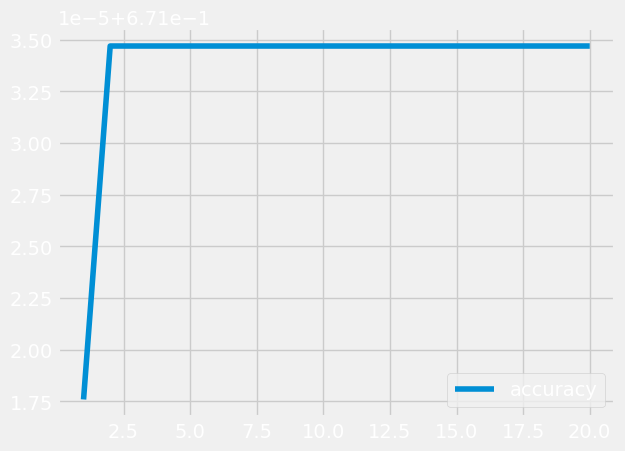

In [96]:
# plotting the accuracy
df_edited = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
df_edited.plot(y = 'accuracy')